## First, I'll load the required data and setup keras settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# use non standard flow_from_directory
from utils.image_preprocessing_ver2 import ImageDataGenerator
# it outputs y_batch that contains embeddings

from utils.mobilenet import get_mobilenet
import keras
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt
from keras.layers import Activation, GlobalAveragePooling2D, Dropout, Dense, Input
%matplotlib inline

Using TensorFlow backend.


In [3]:
logit_dir = 'data/face_emb_logits/'

In [4]:
train_logits = np.load(logit_dir + 'train_set.npy')[()]
val_logits = np.load(logit_dir + 'test_set.npy')[()]


In [5]:
data_dir = "/home/prudhvi/Desktop/Datasets/lfw/lfw_mtcnn_160_split/"

In [6]:
def fixed_image_stand(image):
    return (tf.cast(image, tf.float32) - 127.5)/128

In [7]:
train_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function = fixed_image_stand
)

test_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function = fixed_image_stand
)

# note: i'm also passing dicts of logits
train_generator = train_generator.flow_from_directory(
    data_dir + 'train/', train_logits,
    target_size=(160, 160),
    batch_size=64,
    class_mode = 'embedding',
)

val_generator = test_generator.flow_from_directory(
    data_dir + 'test', val_logits,
    target_size=(160, 160),
    batch_size=64,
    class_mode = 'embedding',
)

Found 12020 images belonging to 1 classes.
Found 1213 images belonging to 1 classes.


## Create your Mobilenet model

In [25]:
def get_mobilenet(input_size = 160, alpha = 1 ):
    
    input_shape = (input_size, input_size, 3)
    base_model = MobileNet(
        include_top=False, weights='imagenet', 
        input_shape=input_shape, alpha=alpha
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.25)(x)
#     logits = Dense(512, kernel_regularizer = regularizers.l2(0.001))(x)
    logits = Dense(512)(x)
    l2_norm = Lambda(lambda  x: K.l2_normalize(x,axis=1))(logits)
    model = Model(base_model.input, l2_norm)
    
    for layer in model.layers[:-13]:
        layer.trainable = False
    return model

model = get_mobilenet()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 162, 162, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
__________

In [28]:
def embedding_loss(y_true, y_pred):    
    
    return K.mean(K.sum(K.square(y_true - y_pred), axis = 1))

In [29]:

model.compile(
    optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True), #SGD has the best generalization capability
#     optimizer = optimizers.RMSprop(lr=1e-5),
    loss=embedding_loss, 
    metrics=[embedding_loss]
)

In [30]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_embedding_loss', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30
400/400 [==============================] - 7644s 19s/step - loss: 1.1787 - embedding_loss: 1.1787 - val_loss: 1.8890 - val_embedding_loss: 1.8890
Epoch 2/30
 55/400 [===>..........................] - ETA: 14:43 - loss: 0.9492 - embedding_loss: 0.9492

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.702481). Check your callbacks.
  % delta_t_median)


 57/400 [===>..........................] - ETA: 14:25 - loss: 0.9473 - embedding_loss: 0.9473

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.438212). Check your callbacks.
  % delta_t_median)


400/400 [==============================] - 809s 2s/step - loss: 0.8569 - embedding_loss: 0.8569 - val_loss: 1.7901 - val_embedding_loss: 1.7901
Epoch 3/30
400/400 [==============================] - 170s 424ms/step - loss: 0.7082 - embedding_loss: 0.7082 - val_loss: 1.9012 - val_embedding_loss: 1.9012
Epoch 4/30
400/400 [==============================] - 135s 338ms/step - loss: 0.5910 - embedding_loss: 0.5910 - val_loss: 1.8225 - val_embedding_loss: 1.8225
Epoch 5/30
400/400 [==============================] - 112s 279ms/step - loss: 0.4814 - embedding_loss: 0.4814 - val_loss: 1.8605 - val_embedding_loss: 1.8605
Epoch 6/30
400/400 [==============================] - 189s 473ms/step - loss: 0.4532 - embedding_loss: 0.4532 - val_loss: 1.8599 - val_embedding_loss: 1.8599
Epoch 7/30
400/400 [==============================] - 159s 397ms/step - loss: 0.4382 - embedding_loss: 0.4382 - val_loss: 1.8471 - val_embedding_loss: 1.8471
Epoch 8/30
400/400 [==============================] - 183s 459ms/s

### Loss/epoch plots

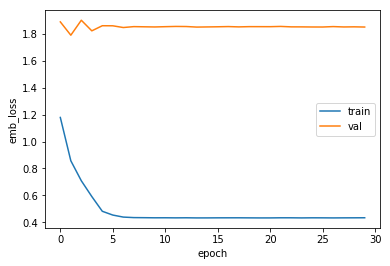

In [31]:



plt.plot(model.history.history['embedding_loss'], label='train');
plt.plot(model.history.history['val_embedding_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('emb_loss');

### Export your model to disk

In [47]:
from keras import backend as K

K.set_learning_phase(0)  # all new operations will be in test mode from now on

# serialize the model and get its weights, for quick re-building
json_config = model.to_json()
weights = model.get_weights()

# re-build a model where the learning phase is now hard-coded to 0
from keras.models import model_from_json
new_model = model_from_json(json_config, {'relu6': keras.applications.mobilenet.mobilenet.relu6})
new_model.set_weights(weights)

In [55]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

sess = K.get_session()
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), [new_model.output.op.name])
graph_io.write_graph(constant_graph, './', 'train.pb', as_text=False)
print('saved the freezed graph (ready for inference)')

INFO:tensorflow:Froze 137 variables.
Converted 137 variables to const ops.
saved the freezed graph (ready for inference)
